In [1]:
import time, random
import numpy as np
import pennylane as qml
from qiskit import Aer, transpile, execute
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import random_clifford, Pauli, Statevector
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, edgeitems=10, linewidth=150, suppress=True)

In [2]:
import qiskit
import itertools
from qiskit import *
from qiskit.quantum_info import Clifford, random_clifford
from qiskit.synthesis import synth_clifford_full
from qiskit.quantum_info import hellinger_fidelity as hf

from utils.pauli_checks import ChecksFinder, add_pauli_checks, add_meas_pauli_checks, add_linear_meas_pauli_checks,  search_for_pauli_list
from utils.pauli_checks import gen_initial_layout, gen_final_layout, filter_results, pauli_strings_commute

from utils.utils import norm_dict, total_counts
from utils.vqe_utils import evaluation
from utils.postprocess import singlecheck_postprocess, rightchecks_postprocess, filter_results_reindex

#### I. Calibrating $\tilde{f}$ in the noisy Clifford channel using hardware

In [3]:
total_trials = 1600
num_qubits = 4
def calibration_circuit(Clifford):
    qc = QuantumCircuit(num_qubits)
    
    clifford_circuit = Clifford.to_circuit()
    qc.compose(clifford_circuit, qubits=[0,1,2,3], inplace=True)
    
    qc.measure_all()
    return qc

In [4]:
cali_C_list = []
for i in range(total_trials):
    Clifford = random_clifford(4)
    cali_C_list.append(Clifford)
    
cali_circs = []
for i in range(total_trials):
    circuit = calibration_circuit(cali_C_list[i])
    cali_circs.append(circuit)

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from qiskit.providers.fake_provider import FakeHanoi
from qiskit_aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise

#service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q-ornl/anl/chm185")
service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
# # Make a noise model
fake_backend = FakeHanoi()
# noise_model = NoiseModel.from_backend(fake_backend)

prob_1 = 0.003  # 1-qubit gate
prob_2 = 0.03   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
#add the bitflit error.

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
options = Options(optimization_level=2, resilience_level=1) # choose the proper levels on hardware
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
#     "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}
#backend = service.get_backend("") 
backend = "ibmq_qasm_simulator" # use the simulator for now

In [6]:
with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)
    
    # define physical qubits to be used in the layout arguement
    job = sampler.run(cali_circs, shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    
    result = job.result()
    
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/quantum_chem/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1023: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)


Job ID: co90ck12req8kccbl08g
>>> Job Status: JobStatus.RUNNING


In [7]:
cali_b_lists = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits]: result.quasi_dists[i].binary_probabilities().get(key)})
    cali_b_lists.append(di)

In [8]:
def calibrating_f(cali_b_lists, cali_C_list, num_qubits):
    d = 2**num_qubits
    num_snapshots = len(cali_C_list)
    
    f_tilde = 0.
    for b_dict, clifford in zip(cali_b_lists, cali_C_list):
        F = computing_F(b_dict, clifford, num_qubits)
        f_tilde += np.real((d*F - 1) / (d - 1))
    
    return f_tilde / num_snapshots


def computing_F(b_dict, clifford, num_qubits):
    zero_state = state_reconstruction('0'*num_qubits)
    U = clifford.to_matrix()
    
    F = 0. + 0.j
    denom = 0.
    for b_state in list(b_dict.keys()):
        F += np.trace(zero_state @ U.T.conj() @ state_reconstruction(b_state) @ U) * b_dict.get(b_state)
        denom += b_dict.get(b_state)
    return F / denom


def state_reconstruction(b_str: str):
    '''
    '''
    zero_state = np.array([[1,0],[0,0]])
    one_state = np.array([[0,0], [0,1]])
    rho = [1]
    for i in b_str:
        state_i = zero_state if i=='0' else one_state
        rho = np.kron(rho, state_i)
    return rho

In [9]:
%%time

f_tilde = calibrating_f(cali_b_lists, cali_C_list, num_qubits)
print(f'The calibrated f_tilde is {f_tilde}; while the noiseless reference is {1/(2**num_qubits+1)}')

The calibrated f_tilde is 0.044280598609608285; while the noiseless reference is 0.058823529411764705
CPU times: user 22.5 s, sys: 273 ms, total: 22.8 s
Wall time: 23.9 s


#### II. Perform the standard shadow experiments

In [10]:
# define the ansatz circuit

def hartree_fock_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # prepare the Hartree-Fock state
    qc.x(0)
    qc.x(1)
    return qc

#the circuit without hartree fock preperation
def hydrogen_trial_circuit_noprep(num_qubits):
    qc = QuantumCircuit(num_qubits)
#     # prepare the Hartree-Fock state
#     qc.x(0)
#     qc.x(1)
    
    qc.rx(np.pi/2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cx(2,3)
    
    qc.rz(1.0, 3)
    
    qc.cx(2,3)
    qc.cx(1,2)
    qc.cx(0,1)
    
    qc.rx(-np.pi/2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    
    return qc

def hydrogen_trial_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # prepare the Hartree-Fock state
    qc.x(0)
    qc.x(1)
    
    qc.rx(np.pi/2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cx(2,3)
    
    qc.rz(1.0, 3)
    
    qc.cx(2,3)
    qc.cx(1,2)
    qc.cx(0,1)
    
    qc.rx(-np.pi/2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    
    return qc


def hydrogen_shadow_circuit(Clifford, num_qubits):
    qc = hydrogen_trial_circuit(num_qubits)
    
    clifford_circuit = Clifford.to_circuit()
    qc.compose(clifford_circuit, qubits=[0,1,2,3], inplace=True)
    
    qc.measure_all()
    return qc

def hydrogen_shadow_PCS_circuit(Clifford, num_qubits, num_checks, single_side = False):
    total_qubits = num_qubits + num_checks
    
    qc = hydrogen_trial_circuit(total_qubits)

    clif_qc = Clifford.to_circuit()
    
    characters = ['I', 'Z']
    strings = [''.join(p) for p in itertools.product(characters, repeat=num_qubits)]
    
    test_finder = ChecksFinder(num_qubits, clif_qc)
    p1_list = []
    for string in strings:
        string_list = list(string)
        result = test_finder.find_checks_sym(pauli_group_elem = string_list)
        #print(result.p1_str, result.p2_str)
        p1_list.append([result.p1_str, result.p2_str])
        
    sorted_list = sorted(p1_list, key=lambda s: s[1].count('I'))
    pauli_list = sorted_list[-num_qubits -1:-1]
    
    #
    initial_layout = {}
    for i in range(0, num_qubits):
        initial_layout[i] = [i]

    final_layout = {}
    for i in range(0, num_qubits):
        final_layout[i] = [i]
        
    #add pauli check on two sides:
    #specify the left and right pauli strings
    pcs_qc_list = []
    sign_list = []
    pl_list = []
    pr_list = []

    for i in range(0, num_checks):
        pl = pauli_list[i][0][2:]
        pr = pauli_list[i][1][2:]
        if i == 0:
            temp_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, 0)
            save_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, 0)
            prev_qc = temp_qc
        else:
            temp_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, 0)
            save_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, 0) 
            prev_qc = temp_qc
        pl_list.append(pl)
        pr_list.append(pr)
        sign_list.append(pauli_list[i][0][:2])
        pcs_qc_list.append(save_qc)

    
    qc.compose(pcs_qc_list[-1], qubits=[i for i in range(0, total_qubits)], inplace=True)
    
    qc.measure_all()
    return qc, (sign_list, pl_list, pr_list)

In [11]:
def hydrogen_shadow_PCS_checkprep(Clifford, num_qubits, num_checks, single_side=False):
    total_qubits = num_qubits + num_checks
    qc_prep = hartree_fock_circuit(total_qubits)
    qc = hydrogen_trial_circuit_noprep(total_qubits)
    clif_qc = Clifford.to_circuit()
    
    # Generate all combinations of 'I' and 'Z' for num_qubits
    characters = ['I', 'Z']
    strings = [''.join(p) for p in itertools.product(characters, repeat=num_qubits)]
    
    test_finder = ChecksFinder(num_qubits, clif_qc)
    p1_list = []
    for string in strings:
        string_list = list(string)
        result = test_finder.find_checks_sym(pauli_group_elem = string_list)
        #print(result.p1_str, result.p2_str)
        p1_list.append([result.p1_str, result.p2_str])
        
    sorted_list = sorted(p1_list, key=lambda s: s[1].count('I'))
    pauli_list = sorted_list[-num_qubits -1:-1]
    
    initial_layout = {i: [i] for i in range(num_qubits)}
    final_layout = initial_layout.copy()

    #add pauli check on two sides:
    #specify the left and right pauli strings
    pcs_qc_list = []
    sign_list = []
    pl_list = []
    pr_list = []
            
    commute_pls, commute_prs, commute_signs, anticommute_pls, anticommute_prs, anticommute_signs = classify_pauli_checks(pauli_list, num_checks, prep_str = 'XXXY')

            
    # first add the anticommute checks in the middle of the circuit
    for j in range(0, len(anticommute_pls)):
        pl = anticommute_pls[j]
        pr = anticommute_prs[j]
        sign = anticommute_signs[j]
        if j == 0:
            temp_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, 0)
            save_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, 0)
            prev_qc = temp_qc
        else:
            temp_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, 0)
            save_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, 0) 
            prev_qc = temp_qc
        pl_list.append(pl)
        pr_list.append(pr)
        sign_list.append(sign)
        pcs_qc_list.append(save_qc)

    if len(anticommute_pls) > 0:
        qc.compose(pcs_qc_list[-1], qubits=[i for i in range(0, num_qubits + len(anticommute_pls))], inplace=True)
    
    # then add the commute checks at the beginning of the circuit
    num_commute = len(commute_pls)
    for k in range(0, len(commute_pls)):
        pl = commute_pls[k]
        pr = commute_prs[k]
        sign = commute_signs[k]
        if k == 0:
            temp_qc = add_pauli_checks(qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, num_commute - k)
            save_qc = add_pauli_checks(qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, num_commute - k)
            prev_qc = temp_qc
        else:
            temp_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, num_commute - k)
            save_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False, num_commute - k) 
            prev_qc = temp_qc
        pl_list.append(pl)
        pr_list.append(pr)
        sign_list.append(sign)
        pcs_qc_list.append(save_qc)
    
    if len(commute_pls) > 0:
        qc = pcs_qc_list[-1]
        
    if len(anticommute_pls) == 0:
        qc.compose(clif_qc, inplace=True)

    qc_prep.compose(qc, inplace=True)
    qc_prep.measure_all()
    return qc_prep, (sign_list, pl_list, pr_list)

def classify_pauli_checks(pauli_list, num_checks, prep_str):
    """
    Classifies Pauli checks into commuting and anti-commuting groups based on the preparation string.
    
    Parameters:
    - pauli_list: List of Pauli checks
    - num_checks: Number of checks to classify
    - prep_str: Preparation string to determine commuting or anti-commuting
    
    Returns:
    - Tuple of lists: (commute_pls, commute_prs, commute_signs, anticommute_pls, anticommute_prs, anticommute_signs)
    """
    commute_pls, commute_prs, commute_signs = [], [], []
    anticommute_pls, anticommute_prs, anticommute_signs = [], [], []
    
    for i in range(num_checks):
        pl, pr = pauli_list[i][0][2:], pauli_list[i][1][2:]
        sign = pauli_list[i][0][:2]
        
        if pauli_strings_commute(pl, prep_str):
            commute_pls.append(pl)
            commute_prs.append(pr)
            commute_signs.append(sign)
        else:
            anticommute_pls.append(pl)
            anticommute_prs.append(pr)
            anticommute_signs.append(sign)
    
    return (commute_pls, commute_prs, commute_signs, anticommute_pls, anticommute_prs, anticommute_signs)

    commute_pls, commute_prs, commute_signs, anticommute_pls, anticommute_prs, anticommute_signs = classify_pauli_checks(pauli_list, num_checks, 'XXXY')
    

In [12]:
num_qubits = 4
num_checks = 4
C_list = []
for i in range(total_trials):
    Clifford = random_clifford(4)
    C_list.append(Clifford)
circs_list = []
checks_list = []
for check_id in range(1, num_checks + 1):
    circs = []
    checks = []
    for i in range(total_trials):
        circ, check = hydrogen_shadow_PCS_circuit(C_list[i], num_qubits, check_id, True)
        circs.append(circ)
        checks.append(check)
    circs_list.append(circs)
    checks_list.append(checks)
    
orign_circs = []
for i in range(total_trials):
    circuit = hydrogen_shadow_circuit(C_list[i], num_qubits)
    orign_circs.append(circuit)

In [13]:
num_qubits = 4
num_checks = 4

prepcheck_circs_list = []
prepchecks_list = []
for check_id in range(1, num_checks + 1):
    circs = []
    checks = []
    for i in range(total_trials):
        circ, check = hydrogen_shadow_PCS_checkprep(C_list[i], num_qubits, check_id, True)
        circs.append(circ)
        checks.append(check)
    prepcheck_circs_list.append(circs)
    prepchecks_list.append(checks)

In [14]:
b_lists_filtered = []
check_id = 1
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in checks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    output_dist = rightchecks_postprocess(b_lists_check[i], num_qubits, check_id, pr_list = checks_list[check_id - 1][i][2])
    filted_dist = filter_results_reindex(output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


Job ID: co90g9l0cpthsc8rjaj0
>>> Job Status: JobStatus.RUNNING
0.8359070883524679
0.9442270284660793
0.8780537724121307
0.8868414080322354
0.8878276822709827
0.9084207366613182
0.9564018862592728
0.8378335701283122
0.83787493918548
0.8947048196146037
0.8926815009171575
0.9072415304986974
0.8437581580407538
0.8026254842922582
0.9270223567220363
0.8976500127308383
0.871261570381224
0.7821068253817572
0.9123085661797485
0.8799941222241844
0.8740311033978395
0.7703306688260734
0.8584204348301699
0.9250390333602004
0.8780140112323177
0.8437354363995065
0.8702495563151068
0.8065974622337915
0.9132593101649844
0.835930552630972
0.7927214751420125
0.8760437315342068
0.8633460932078335
0.8300509753809762
0.9738252590034308
0.9544353117328245
0.8378584855831973
0.8536372551208554
0.8292811443627335
0.7566156511175895
0.8232638661317289
0.8408368209554588
0.867279406876373
0.8212885720024458
0.9103637503899321
0.8026234471795946
0.8887951932604496
0.8418220391550011
0.9189808345345454
0.847677249

In [15]:
b_lists_check[1]

{'00000': 0.029178650589258743,
 '00001': 0.001834019258851788,
 '00010': 0.026250553005369423,
 '00011': 0.003780615623638422,
 '00100': 0.024331460975172775,
 '00101': 0.0008504983758864628,
 '00110': 0.04597174657960461,
 '00111': 0.0038088333499326664,
 '01000': 0.03312407708536261,
 '01001': 0.0008586715751447578,
 '01010': 0.04498339626780364,
 '01011': 0.0008606871798927633,
 '01100': 0.04206516086044969,
 '01101': 0.002829102449923243,
 '01110': 0.02940469982382461,
 '01111': 0.0028232771300660624,
 '10000': 0.0027867612929671627,
 '10001': 0.08192157917503813,
 '10010': 0.008665697615176389,
 '10011': 0.09194063747584,
 '10100': 0.006716170630915679,
 '10101': 0.08612202358386636,
 '10110': 0.003800947741033216,
 '10111': 0.07844537257700958,
 '11000': 0.0037829483992796293,
 '11001': 0.08216180333735461,
 '11010': 0.002813252222843655,
 '11011': 0.08233939466823177,
 '11100': 0.005763594896197571,
 '11101': 0.07847196125547048,
 '11110': 0.003797893792171203,
 '11111': 0.0875

In [16]:
output_dist = rightchecks_postprocess(b_lists_check[1], num_qubits, check_id, pr_list = checks_list[check_id - 1][1][2])
output_dist

{'00000': 0.029178650589258743,
 '10001': 0.001834019258851788,
 '00010': 0.026250553005369423,
 '10011': 0.003780615623638422,
 '00100': 0.024331460975172775,
 '10101': 0.0008504983758864628,
 '00110': 0.04597174657960461,
 '10111': 0.0038088333499326664,
 '01000': 0.03312407708536261,
 '11001': 0.0008586715751447578,
 '01010': 0.04498339626780364,
 '11011': 0.0008606871798927633,
 '01100': 0.04206516086044969,
 '11101': 0.002829102449923243,
 '01110': 0.02940469982382461,
 '11111': 0.0028232771300660624,
 '10000': 0.0027867612929671627,
 '00001': 0.08192157917503813,
 '10010': 0.008665697615176389,
 '00011': 0.09194063747584,
 '10100': 0.006716170630915679,
 '00101': 0.08612202358386636,
 '10110': 0.003800947741033216,
 '00111': 0.07844537257700958,
 '11000': 0.0037829483992796293,
 '01001': 0.08216180333735461,
 '11010': 0.002813252222843655,
 '01011': 0.08233939466823177,
 '11100': 0.005763594896197571,
 '01101': 0.07847196125547048,
 '11110': 0.003797893792171203,
 '01111': 0.0875

In [17]:
circs_list[0][1].draw()

┌───┐┌─────────┐                                       ┌──────────┐   »
   q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────■──┤ Rx(-π/2) ├─■─»
        ├───┤└──┬───┬──┘┌─┴─┐                             ┌─┴─┐└──┬───┬───┘ │ »
   q_1: ┤ X ├───┤ H ├───┤ X ├──■───────────────────────■──┤ X ├───┤ H ├─────┼─»
        ├───┤   └───┘   └───┘┌─┴─┐                   ┌─┴─┐├───┤   ├───┤     │ »
   q_2: ┤ H ├────────────────┤ X ├──■─────────────■──┤ X ├┤ H ├───┤ H ├─────┼─»
        ├───┤                └───┘┌─┴─┐┌───────┐┌─┴─┐├───┤├───┤   └───┘     │ »
   q_3: ┤ H ├─────────────────────┤ X ├┤ Rz(1) ├┤ X ├┤ H ├┤ S ├─────────────┼─»
        ├───┤                     └───┘└───────┘└───┘└───┘└───┘             │ »
   q_4: ┤ H ├───────────────────────────────────────────────────────────────■─»
        └───┘                                                                 »
meas: 5/══════════════════════════════════════════════════════════════════════»
                                                                              »
«                       ┌───┐                                  ░ ┌─┐         »
«   q_0: ───────■────■──┤ Z ├──────────────────────────────────░─┤M├─────────»
«        ┌───┐┌─┴─┐  │  ├───┤        ┌───┐┌───┐                ░ └╥┘┌─┐      »
«   q_1: ┤ S ├┤ X ├──┼──┤ S ├─X───■──┤ S ├┤ H ├──■─────────────░──╫─┤M├──────»
«        └───┘└───┘  │  └───┘ │   │  └───┘└───┘┌─┴─┐┌───┐┌───┐ ░  ║ └╥┘┌─┐   »
«   q_2: ────────────┼────────┼───┼────────────┤ X ├┤ S ├┤ H ├─░──╫──╫─┤M├───»
«                  ┌─┴─┐┌───┐ │ ┌─┴─┐┌───┐     └───┘└───┘└───┘ ░  ║  ║ └╥┘┌─┐»
«   q_3: ──────────┤ X ├┤ H ├─X─┤ X ├┤ X ├─────────────────────░──╫──╫──╫─┤M├»
«        ┌───┐     └───┘└───┘   └───┘└───┘                     ░  ║  ║  ║ └╥┘»
«   q_4: ┤ H ├─────────────────────────────────────────────────░──╫──╫──╫──╫─»
«        └───┘                                                 ░  ║  ║  ║  ║ »
«meas: 5/═════════════════════════════════════════════════════════╩══╩══╩══╩═»
«                                                                 0  1  2  3 »
«           
«   q_0: ───
«           
«   q_1: ───
«           
«   q_2: ───
«           
«   q_3: ───
«        ┌─┐
«   q_4: ┤M├
«        └╥┘
«meas: 5/═╩═
«         4

In [18]:
bit_list = ['1' if i == '+1' else '0' for i in checks_list[check_id-1][1][0][check_id - 1::-1]]
bit_list

['1']

In [19]:
filted_dist = filter_results_reindex(output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
filted_dist

{'0000': 0.029178650589258743,
 '0010': 0.026250553005369423,
 '0100': 0.024331460975172775,
 '0110': 0.04597174657960461,
 '1000': 0.03312407708536261,
 '1010': 0.04498339626780364,
 '1100': 0.04206516086044969,
 '1110': 0.02940469982382461,
 '0001': 0.08192157917503813,
 '0011': 0.09194063747584,
 '0101': 0.08612202358386636,
 '0111': 0.07844537257700958,
 '1001': 0.08216180333735461,
 '1011': 0.08233939466823177,
 '1101': 0.07847196125547048,
 '1111': 0.08751451120642226}

In [20]:
len(circs_list[0])

1600

In [21]:
len(prepcheck_circs_list[0])

1600

In [23]:
circs_list[1][0].draw()

┌───┐┌─────────┐                                       ┌──────────┐»
   q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────■──┤ Rx(-π/2) ├»
        ├───┤└──┬───┬──┘┌─┴─┐                             ┌─┴─┐└──┬───┬───┘»
   q_1: ┤ X ├───┤ H ├───┤ X ├──■───────────────────────■──┤ X ├───┤ H ├────»
        ├───┤   └───┘   └───┘┌─┴─┐                   ┌─┴─┐├───┤   └───┘    »
   q_2: ┤ H ├────────────────┤ X ├──■─────────────■──┤ X ├┤ H ├────────────»
        ├───┤                └───┘┌─┴─┐┌───────┐┌─┴─┐├───┤└───┘            »
   q_3: ┤ H ├─────────────────────┤ X ├┤ Rz(1) ├┤ X ├┤ H ├─────────────────»
        ├───┤                     └───┘└───────┘└───┘└───┘                 »
   q_4: ┤ H ├──────────────────────────────────────────────────────────────»
        ├───┤                                                              »
   q_5: ┤ H ├──────────────────────────────────────────────────────────────»
        └───┘                                                              »
meas: 6/═══════════════════════════════════════════════════════════════════»
                                                                           »
«             ┌───┐┌───┐                            ┌───┐┌───┐               »
«   q_0: ─────┤ X ├┤ H ├─────────────────────X──────┤ X ├┤ S ├───────X────■──»
«        ┌───┐└─┬─┘└───┘┌───┐┌───┐┌───┐      │ ┌───┐└─┬─┘└───┘┌───┐  │    │  »
«   q_1: ┤ X ├──┼───────┤ Y ├┤ H ├┤ S ├──────┼─┤ X ├──┼────■──┤ X ├──┼────┼──»
«        └─┬─┘  │  ┌───┐└─┬─┘├───┤├───┤┌───┐ │ └─┬─┘  │    │  ├───┤  │  ┌─┴─┐»
«   q_2: ──┼────┼──┤ X ├──┼──┤ Y ├┤ H ├┤ S ├─┼───■────┼────┼──┤ X ├──X──┤ X ├»
«          │    │  └─┬─┘  │  └─┬─┘├───┤├───┤ │        │  ┌─┴─┐└─┬─┘┌───┐└───┘»
«   q_3: ──┼────┼────┼────┼────┼──┤ Y ├┤ H ├─X────────■──┤ X ├──■──┤ X ├─────»
«          │    │    │    │    │  └─┬─┘├───┤             └───┘     └───┘     »
«   q_4: ──┼────■────┼────■────■────■──┤ H ├─────────────────────────────────»
«          │         │  ┌───┐          └───┘                                 »
«   q_5: ──■─────────■──┤ H ├────────────────────────────────────────────────»
«                       └───┘                                                »
«meas: 6/════════════════════════════════════════════════════════════════════»
«                                                                            »
«        ┌───┐┌───┐ ░ ┌─┐               
«   q_0: ┤ H ├┤ Z ├─░─┤M├───────────────
«        └───┘└───┘ ░ └╥┘┌─┐            
«   q_1: ───────────░──╫─┤M├────────────
«        ┌───┐      ░  ║ └╥┘┌─┐         
«   q_2: ┤ X ├──────░──╫──╫─┤M├─────────
«        └───┘      ░  ║  ║ └╥┘┌─┐      
«   q_3: ───────────░──╫──╫──╫─┤M├──────
«                   ░  ║  ║  ║ └╥┘┌─┐   
«   q_4: ───────────░──╫──╫──╫──╫─┤M├───
«                   ░  ║  ║  ║  ║ └╥┘┌─┐
«   q_5: ───────────░──╫──╫──╫──╫──╫─┤M├
«                   ░  ║  ║  ║  ║  ║ └╥┘
«meas: 6/══════════════╩══╩══╩══╩══╩══╩═
«                      0  1  2  3  4  5

In [24]:
prepcheck_circs_list[1][0].draw()

┌───┐     ┌───┐┌─────────┐                                            »
   q_0: ┤ X ├─────┤ X ├┤ Rx(π/2) ├────────────■───────────────────────────────»
        ├───┤┌───┐└─┬─┘└─────────┘┌───┐┌───┐┌─┴─┐                             »
   q_1: ┤ X ├┤ X ├──┼─────────────┤ Y ├┤ H ├┤ X ├──■───────────────────────■──»
        └───┘└─┬─┘  │     ┌───┐   └─┬─┘├───┤├───┤┌─┴─┐                   ┌─┴─┐»
   q_2: ───────┼────┼─────┤ X ├─────┼──┤ Y ├┤ H ├┤ X ├──■─────────────■──┤ X ├»
               │    │     └─┬─┘     │  └─┬─┘├───┤├───┤┌─┴─┐┌───────┐┌─┴─┐├───┤»
   q_3: ───────┼────┼───────┼───────┼────┼──┤ Y ├┤ H ├┤ X ├┤ Rz(1) ├┤ X ├┤ H ├»
        ┌───┐  │    │       │       │    │  └─┬─┘├───┤└───┘└───────┘└───┘└───┘»
   q_4: ┤ H ├──┼────■───────┼───────■────■────■──┤ H ├────────────────────────»
        ├───┤  │            │     ┌───┐          └───┘                        »
   q_5: ┤ H ├──■────────────■─────┤ H ├───────────────────────────────────────»
        └───┘                     └───┘                                       »
meas: 6/══════════════════════════════════════════════════════════════════════»
                                                                              »
«             ┌──────────┐┌───┐        ┌───┐┌───┐                    ┌───┐┌───┐»
«   q_0: ──■──┤ Rx(-π/2) ├┤ H ├──────X─┤ X ├┤ S ├────────────X────■──┤ H ├┤ Z ├»
«        ┌─┴─┐└──┬───┬───┘├───┤┌───┐ │ └─┬─┘├───┤     ┌───┐  │    │  └───┘└───┘»
«   q_1: ┤ X ├───┤ H ├────┤ H ├┤ S ├─┼───┼──┤ X ├──■──┤ X ├──┼────┼────────────»
«        ├───┤   ├───┤    ├───┤└───┘ │   │  └─┬─┘  │  ├───┤  │  ┌─┴─┐┌───┐     »
«   q_2: ┤ H ├───┤ H ├────┤ S ├──────┼───┼────■────┼──┤ X ├──X──┤ X ├┤ X ├─────»
«        ├───┤   └───┘    └───┘      │   │       ┌─┴─┐└─┬─┘┌───┐└───┘└───┘     »
«   q_3: ┤ H ├───────────────────────X───■───────┤ X ├──■──┤ X ├───────────────»
«        └───┘                                   └───┘     └───┘               »
«   q_4: ──────────────────────────────────────────────────────────────────────»
«                                                                              »
«   q_5: ──────────────────────────────────────────────────────────────────────»
«                                                                              »
«meas: 6/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«         ░ ┌─┐               
«   q_0: ─░─┤M├───────────────
«         ░ └╥┘┌─┐            
«   q_1: ─░──╫─┤M├────────────
«         ░  ║ └╥┘┌─┐         
«   q_2: ─░──╫──╫─┤M├─────────
«         ░  ║  ║ └╥┘┌─┐      
«   q_3: ─░──╫──╫──╫─┤M├──────
«         ░  ║  ║  ║ └╥┘┌─┐   
«   q_4: ─░──╫──╫──╫──╫─┤M├───
«         ░  ║  ║  ║  ║ └╥┘┌─┐
«   q_5: ─░──╫──╫──╫──╫──╫─┤M├
«         ░  ║  ║  ║  ║  ║ └╥┘
«meas: 6/════╩══╩══╩══╩══╩══╩═
«            0  1  2  3  4  5

In [25]:
prepcheck_circs_list[0][5].draw()

┌───┐   ┌─────────┐                                       ┌──────────┐»
   q_0: ┤ X ├─■─┤ Rx(π/2) ├──■─────────────────────────────────■──┤ Rx(-π/2) ├»
        ├───┤ │ └──┬───┬──┘┌─┴─┐                             ┌─┴─┐└──┬───┬───┘»
   q_1: ┤ X ├─┼────┤ H ├───┤ X ├──■───────────────────────■──┤ X ├───┤ H ├────»
        └───┘ │    ├───┤   ├───┤┌─┴─┐                   ┌─┴─┐├───┤   ├───┤    »
   q_2: ──────┼────┤ X ├───┤ H ├┤ X ├──■─────────────■──┤ X ├┤ H ├───┤ H ├────»
              │    └─┬─┘   └───┘├───┤┌─┴─┐┌───────┐┌─┴─┐├───┤├───┤   └───┘    »
   q_3: ──────┼──────┼───────■──┤ H ├┤ X ├┤ Rz(1) ├┤ X ├┤ H ├┤ H ├────────────»
        ┌───┐ │      │       │  ├───┤└───┘└───────┘└───┘└───┘└───┘            »
   q_4: ┤ H ├─■──────■───────■──┤ H ├─────────────────────────────────────────»
        └───┘                   └───┘                                         »
meas: 5/══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌───┐               ┌───┐┌───┐                                        »
«   q_0: ┤ X ├───────■───────┤ X ├┤ X ├────────────────────────────────────────»
«        └─┬─┘┌───┐  │  ┌───┐└─┬─┘└───┘┌───┐┌───┐          ┌───┐┌───┐          »
«   q_1: ──┼──┤ S ├──┼──┤ X ├──┼────■──┤ S ├┤ H ├──■───────┤ X ├┤ Z ├──────────»
«          │  ├───┤  │  └─┬─┘  │    │  ├───┤├───┤┌─┴─┐┌───┐└─┬─┘├───┤┌───┐┌───┐»
«   q_2: ──■──┤ H ├──┼────■────┼────┼──┤ X ├┤ H ├┤ X ├┤ H ├──■──┤ S ├┤ H ├┤ X ├»
«             └───┘┌─┴─┐┌───┐  │  ┌─┴─┐└─┬─┘├───┤└───┘└───┘     └───┘└───┘└───┘»
«   q_3: ──────────┤ X ├┤ H ├──■──┤ X ├──■──┤ X ├──────────────────────────────»
«                  └───┘└───┘     └───┘     └───┘                              »
«   q_4: ──────────────────────────────────────────────────────────────────────»
«                                                                              »
«meas: 5/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«         ░ ┌─┐            
«   q_0: ─░─┤M├────────────
«         ░ └╥┘┌─┐         
«   q_1: ─░──╫─┤M├─────────
«         ░  ║ └╥┘┌─┐      
«   q_2: ─░──╫──╫─┤M├──────
«         ░  ║  ║ └╥┘┌─┐   
«   q_3: ─░──╫──╫──╫─┤M├───
«         ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ─░──╫──╫──╫──╫─┤M├
«         ░  ║  ║  ║  ║ └╥┘
«meas: 5/════╩══╩══╩══╩══╩═
«            0  1  2  3  4

In [26]:
prep_b_lists_filtered = []
check_id = 1
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run( prepcheck_circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

prep_b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    prep_b_lists_check.append(di)


prep_filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in prepchecks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    prep_output_dist = rightchecks_postprocess(prep_b_lists_check[i], num_qubits, check_id, pr_list = prepchecks_list[check_id - 1][i][2])
    prep_filted_dist = filter_results_reindex(prep_output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(i, total_counts(prep_filted_dist))
    prep_filtered_b_lists.append(prep_filted_dist)
prep_b_lists_filtered.append(prep_filtered_b_lists)


Job ID: co90kl3l9hecuf4v5m1g
>>> Job Status: JobStatus.RUNNING
0 0.7830314786548019
1 0.9442270284660793
2 0.8780537724121307
3 0.8065239319940558
4 0.8094717106763633
5 0.8388970195968144
6 0.9564018862592728
7 0.8378335701283122
8 0.7889168538408404
9 0.8947048196146037
10 0.8926815009171575
11 0.9072415304986974
12 0.8437581580407538
13 0.7448406289515974
14 0.9270223567220363
15 0.8976500127308383
16 0.8232677836560817
17 0.7468600752727094
18 0.8417766742229933
19 0.8202559892411048
20 0.8740311033978395
21 0.7703306688260734
22 0.8584204348301699
23 0.9250390333602004
24 0.8780140112323177
25 0.8437354363995065
26 0.8702495563151068
27 0.7683865173230265
28 0.9132593101649844
29 0.835930552630972
30 0.7408375867343151
31 0.8760437315342068
32 0.8085089790666071
33 0.8300509753809762
34 0.9738252590034308
35 0.9250593636192218
36 0.8378584855831973
37 0.814459269323546
38 0.8292811443627335
39 0.7174431498543742
40 0.8232638661317289
41 0.7752196591757924
42 0.867279406876373
43 0

In [27]:
check_id = 2
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in checks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    output_dist = rightchecks_postprocess(b_lists_check[i], num_qubits, check_id, pr_list = checks_list[check_id - 1][i][2])
    filted_dist = filter_results_reindex(output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


Job ID: co90lh3l9hecuf4v5ob0
>>> Job Status: JobStatus.RUNNING
0.794761422489472
0.8462534184797409
0.7761875229441971
0.7173672597746902
0.6967026979348129
0.7465802003323646
0.9082878521785629
0.7341095600157779
0.8074572197605292
0.7712546564341198
0.7525821793564923
0.7917674380812185
0.7291210069435798
0.6988338960683246
0.8369561085584134
0.7536892129785947
0.7257817596488076
0.6944803826905357
0.7379575456765397
0.819360628180368
0.7406498094291631
0.7055842049793852
0.7823531784842495
0.7791848783738847
0.7742653107467358
0.7280891822770672
0.7556175767917608
0.745752657663272
0.7338939901938922
0.707681024898703
0.6752451237447288
0.7951816080149143
0.7399839903355548
0.7243045629139576
0.8454769974635187
0.8552396921837789
0.7526692725994508
0.7595890036294738
0.7410989378173392
0.6527522907456708
0.7281948723754084
0.7095552577695212
0.7429284273635519
0.7321731397786907
0.7887783914789328
0.7006695169210462
0.7673308542866664
0.8095197033168106
0.7398231890182583
0.73995592

In [28]:
prepcheck_circs_list[2-1][0].draw()

┌───┐     ┌───┐┌─────────┐                                            »
   q_0: ┤ X ├─────┤ X ├┤ Rx(π/2) ├────────────■───────────────────────────────»
        ├───┤┌───┐└─┬─┘└─────────┘┌───┐┌───┐┌─┴─┐                             »
   q_1: ┤ X ├┤ X ├──┼─────────────┤ Y ├┤ H ├┤ X ├──■───────────────────────■──»
        └───┘└─┬─┘  │     ┌───┐   └─┬─┘├───┤├───┤┌─┴─┐                   ┌─┴─┐»
   q_2: ───────┼────┼─────┤ X ├─────┼──┤ Y ├┤ H ├┤ X ├──■─────────────■──┤ X ├»
               │    │     └─┬─┘     │  └─┬─┘├───┤├───┤┌─┴─┐┌───────┐┌─┴─┐├───┤»
   q_3: ───────┼────┼───────┼───────┼────┼──┤ Y ├┤ H ├┤ X ├┤ Rz(1) ├┤ X ├┤ H ├»
        ┌───┐  │    │       │       │    │  └─┬─┘├───┤└───┘└───────┘└───┘└───┘»
   q_4: ┤ H ├──┼────■───────┼───────■────■────■──┤ H ├────────────────────────»
        ├───┤  │            │     ┌───┐          └───┘                        »
   q_5: ┤ H ├──■────────────■─────┤ H ├───────────────────────────────────────»
        └───┘                     └───┘                                       »
meas: 6/══════════════════════════════════════════════════════════════════════»
                                                                              »
«             ┌──────────┐┌───┐        ┌───┐┌───┐                    ┌───┐┌───┐»
«   q_0: ──■──┤ Rx(-π/2) ├┤ H ├──────X─┤ X ├┤ S ├────────────X────■──┤ H ├┤ Z ├»
«        ┌─┴─┐└──┬───┬───┘├───┤┌───┐ │ └─┬─┘├───┤     ┌───┐  │    │  └───┘└───┘»
«   q_1: ┤ X ├───┤ H ├────┤ H ├┤ S ├─┼───┼──┤ X ├──■──┤ X ├──┼────┼────────────»
«        ├───┤   ├───┤    ├───┤└───┘ │   │  └─┬─┘  │  ├───┤  │  ┌─┴─┐┌───┐     »
«   q_2: ┤ H ├───┤ H ├────┤ S ├──────┼───┼────■────┼──┤ X ├──X──┤ X ├┤ X ├─────»
«        ├───┤   └───┘    └───┘      │   │       ┌─┴─┐└─┬─┘┌───┐└───┘└───┘     »
«   q_3: ┤ H ├───────────────────────X───■───────┤ X ├──■──┤ X ├───────────────»
«        └───┘                                   └───┘     └───┘               »
«   q_4: ──────────────────────────────────────────────────────────────────────»
«                                                                              »
«   q_5: ──────────────────────────────────────────────────────────────────────»
«                                                                              »
«meas: 6/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«         ░ ┌─┐               
«   q_0: ─░─┤M├───────────────
«         ░ └╥┘┌─┐            
«   q_1: ─░──╫─┤M├────────────
«         ░  ║ └╥┘┌─┐         
«   q_2: ─░──╫──╫─┤M├─────────
«         ░  ║  ║ └╥┘┌─┐      
«   q_3: ─░──╫──╫──╫─┤M├──────
«         ░  ║  ║  ║ └╥┘┌─┐   
«   q_4: ─░──╫──╫──╫──╫─┤M├───
«         ░  ║  ║  ║  ║ └╥┘┌─┐
«   q_5: ─░──╫──╫──╫──╫──╫─┤M├
«         ░  ║  ║  ║  ║  ║ └╥┘
«meas: 6/════╩══╩══╩══╩══╩══╩═
«            0  1  2  3  4  5

In [29]:

check_id = 2
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run( prepcheck_circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

prep_b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    prep_b_lists_check.append(di)


prep_filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in prepchecks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    prep_output_dist = rightchecks_postprocess(prep_b_lists_check[i], num_qubits, check_id, pr_list = prepchecks_list[check_id - 1][i][2])
    prep_filted_dist = filter_results_reindex(prep_output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(i, total_counts(prep_filted_dist))
    prep_filtered_b_lists.append(prep_filted_dist)
prep_b_lists_filtered.append(prep_filtered_b_lists)


Job ID: co90mgosts3phnua14q0
>>> Job Status: JobStatus.RUNNING
0 0.7065637692967506
1 0.7881979900397695
2 0.74384583983488
3 0.6761890375895528
4 0.6517095846701627
5 0.6909803625576147
6 0.870205311883797
7 0.7341095600157779
8 0.7535832840633657
9 0.7349803337114332
10 0.7525821793564923
11 0.7496022165148212
12 0.685015794309371
13 0.6204117873454362
14 0.7801074236357926
15 0.7036794632057397
16 0.6562314291650273
17 0.6483247096380778
18 0.694862277928344
19 0.7742465806952807
20 0.6926164684766314
21 0.7055842049793852
22 0.7823531784842495
23 0.7290869788451848
24 0.7203652790471196
25 0.6995008587345226
26 0.7556175767917608
27 0.6488158187644953
28 0.7338939901938922
29 0.707681024898703
30 0.5998047277710983
31 0.7951816080149143
32 0.6909488914704981
33 0.6772492065309579
34 0.7767665526931368
35 0.777179299933582
36 0.7526692725994508
37 0.6929247823578809
38 0.699945036490589
39 0.6027651155362792
40 0.7281948723754084
41 0.6497656568827864
42 0.6772406511473847
43 0.6880

In [30]:

check_id = 3
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in checks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    output_dist = rightchecks_postprocess(b_lists_check[i], num_qubits, check_id, pr_list = checks_list[check_id - 1][i][2])
    filted_dist = filter_results_reindex(output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


Job ID: co90nmh2req8kccblrfg
>>> Job Status: JobStatus.RUNNING
0.7085807989581827
0.8180146843762148
0.6721889876962657
0.5955638300632579
0.6178796688377368
0.6494149752401494
0.814135567762081
0.6152383686399322
0.6977080113508688
0.6545264896477474
0.6895823639921971
0.7042864014871072
0.6389831557136375
0.653809845558649
0.7398738766136537
0.6523409382962763
0.6739553851453829
0.6207472104562047
0.650810322003069
0.7045827622582466
0.6130728520665296
0.6230630751508989
0.7334808486148217
0.6923272449711212
0.6408819096484256
0.6287581985004318
0.6574246101749861
0.6426468827566744
0.6398158008699257
0.6016229487202839
0.6141985235059452
0.7280955256212491
0.6693292332868279
0.6368475578676546
0.7560738771990845
0.7524864848628109
0.6300971017235086
0.7291079797449016
0.6520203573686293
0.5594611133741373
0.6527383328790514
0.6163574292263251
0.650933630234677
0.655613107874273
0.6536677402610896
0.6615548281237247
0.6796090874439377
0.718365835561745
0.6093578018979063
0.6603167521

0.7210172017909903
0.6789751624808088
0.6830000537632963
0.6209527816829173
0.6539231345640766
0.6164339004858561
0.6369745359785184
0.6074885628072071
0.7063905055793676
0.6781538080647473
0.6231386741024789
0.56517205266075
0.6805561792770664
0.6210781869414569
0.612378931391581
0.6535206392810381
0.6145230536583053
0.6458573216141518
0.7178730098734194
0.6399483070412292
0.6269892066032963
0.6290418834868912
0.6372887015798774
0.6533972363164493
0.7025843194004118
0.5653408925287287
0.7517613874693936
0.5746163452405151
0.6681871519818767
0.6947253499616891
0.7193122253311209
0.6675668771738189
0.6408625264595285
0.5908825774553733
0.6260771979257191
0.7438588793050973
0.6543712800597621
0.6213240294882272
0.6623336619435831
0.6124182647034061
0.7465960683655092
0.7448852409574984
0.6545481914333984
0.6780713429032936
0.6829374105243254
0.6614284549278717
0.603675909487558
0.7153343553831012
0.6237214109306309
0.6444480799564856
0.5506338695179184
0.6358147161441363
0.65729056892910

In [31]:

check_id = 3
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run( prepcheck_circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

prep_b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    prep_b_lists_check.append(di)


prep_filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in prepchecks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    prep_output_dist = rightchecks_postprocess(prep_b_lists_check[i], num_qubits, check_id, pr_list = prepchecks_list[check_id - 1][i][2])
    prep_filted_dist = filter_results_reindex(prep_output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(i, total_counts(prep_filted_dist))
    prep_filtered_b_lists.append(prep_filted_dist)
prep_b_lists_filtered.append(prep_filtered_b_lists)


Job ID: co90qc0sts3phnua1jlg
>>> Job Status: JobStatus.RUNNING
0 0.6085462734347076
1 0.7342288554700764
2 0.6447962788259333
3 0.5603981065117734
4 0.5604452268108918
5 0.6241680358842543
6 0.766948060717729
7 0.5672361328062783
8 0.6349227410265041
9 0.5927926847969922
10 0.6337427213430946
11 0.618087535146556
12 0.5634039437456331
13 0.5851343831313209
14 0.6987914717063635
15 0.6103923874432137
16 0.5662092666588894
17 0.553106973367046
18 0.6430168152667511
19 0.67414087922397
20 0.5795190916586395
21 0.5818806694815157
22 0.674711868451558
23 0.6092914490522064
24 0.5692225019735392
25 0.5610968585046828
26 0.6084210162421414
27 0.5522798879332678
28 0.5917984464057392
29 0.6016229487202839
30 0.5300567724816422
31 0.7280955256212491
32 0.5908199791403677
33 0.5936439002968248
34 0.6874195030011537
35 0.6631398207759999
36 0.5888526047673454
37 0.6448313921176486
38 0.5813438887721061
39 0.5083985346847628
40 0.6154469531132777
41 0.5751336120743944
42 0.5675243355710964
43 0.61

1096 0.5574409028173166
1097 0.6662043764074091
1098 0.6013191681992645
1099 0.5986268338518447
1100 0.5750058451070077
1101 0.5729755313684018
1102 0.5474255763030743
1103 0.7003315915097351
1104 0.6251660435937904
1105 0.5271702878641026
1106 0.6533426657190434
1107 0.6151876852191122
1108 0.6203178256090024
1109 0.6211268988220323
1110 0.6632566066512698
1111 0.5414202721946723
1112 0.6497053522492948
1113 0.6496541178064135
1114 0.5466804238688503
1115 0.6397836518937543
1116 0.6044140316123698
1117 0.6300542072987974
1118 0.6129842317922513
1119 0.5742554692990258
1120 0.6249677798828686
1121 0.5652925895945784
1122 0.6210239926831854
1123 0.6739176842762267
1124 0.5457465130956871
1125 0.6124369028118144
1126 0.6723441823501716
1127 0.6026348043339902
1128 0.6252038177839705
1129 0.5780897342973113
1130 0.6438575384190849
1131 0.6250525669897987
1132 0.5858509810961806
1133 0.5418722125987951
1134 0.5760563758957618
1135 0.6300889767811952
1136 0.6281730898521249
1137 0.602749472

In [32]:

check_id = 4
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in checks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    output_dist = rightchecks_postprocess(b_lists_check[i], num_qubits, check_id, pr_list = checks_list[check_id - 1][i][2])
    filted_dist = filter_results_reindex(output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


Job ID: co90si04e2d51a9nsej0
>>> Job Status: JobStatus.RUNNING
0.6472971100329744
0.6801545737134731
0.5708439659868016
0.5592201968236138
0.5249139100462428
0.5785015795673594
0.7580675920155526
0.5238856722407332
0.6330494994069684
0.6006292734826989
0.6078878748468841
0.59514335462477
0.5818239643655919
0.5673029643366132
0.6810029569815177
0.5534760757112897
0.6132302493446651
0.54595206048202
0.6077843866337271
0.6606383760547632
0.5435502249678983
0.5238870511524348
0.6802329960703087
0.5951168923030414
0.5905270957161366
0.5865192522716952
0.6006188415101449
0.5539999563954119
0.545282794078165
0.5671240503724213
0.5551448556839129
0.6605557600788392
0.5594777817355303
0.6132712564406495
0.687849556422148
0.7227437399176043
0.5995587824193855
0.6444389243469018
0.5922093276061603
0.489533278203072
0.5915624580455878
0.5257553994455035
0.5940221341770769
0.5895373771930799
0.611762357250565
0.5714221756700196
0.5737767611759145
0.6828512141979928
0.5622619797524189
0.613280570580

0.6181461502506681
0.5798887322765809
0.6073772469600754
0.6024890263152767
0.6004669074028938
0.6065384367059544
0.5523842820894753
0.5740575032916296
0.5581992285124797
0.5866432330389082
0.5356640682480793
0.5059883111881145
0.5505812886169026
0.5236766125278896
0.6739016154703708
0.5622973050107466
0.6591900961048165
0.5981815560004526
0.6189008961773959
0.5908026253844596
0.5896445519705998
0.5798355397907499
0.5416701449998087
0.5779304161427818
0.5972025871197889
0.5819389124112034
0.5718773474563649
0.55078822437225
0.4778313983035462
0.6193792210360086
0.514924551985002
0.5416501559220878
0.5866509033052728
0.5496405348080564
0.5943710559436547
0.6207189109286959
0.5852735696512209
0.6427971196938999
0.5798794505157407
0.6444094176211139
0.5859651422531554
0.6494689260592869
0.5895351089411517
0.7222491733448877
0.4952686367953023
0.5747123041460901
0.5949916735237812
0.5612790900055994
0.6127711942564369
0.5386338681712318
0.6005916301810765
0.5451314968198571
0.6140549842130

0.6070656270403854
0.6349665085294501
0.5014323647735718
0.5631914517260174
0.6299462082188438
0.6502902431042183
0.6259206525288287
0.6240340657533404
0.5808583021959202
0.5522229332343047
0.5894338810454035
0.5842724760049619
0.5740633136808373
0.5583848597401087
0.564637563702458
0.6133361942577049
0.5580574233441516
0.6021916247874415
0.6068999611809811
0.5786730207745082
0.6188056497739837
0.6380559326996146
0.5678331939635479
0.5994839729341197
0.5210206140984983
0.6534800324895056
0.6583040802360818
0.5456898274432491
0.7020141994976454
0.6153192190868946
0.5237301050874441
0.609429133933262
0.5805058437738527
0.6123428659141312
0.48861989812778317
0.6254605770755057
0.5538966093319828
0.5975763578471596
0.720295482126511
0.6908040689427162
0.6121099341236204
0.5936065049463095
0.589562446580143
0.4490711749134854
0.6882196161180325
0.5702436778652066
0.5835825802281602
0.5836265544788442
0.5814120100920812
0.616940868362938
0.5424189932128893
0.5462511533823367
0.56223350381734

In [33]:
len(b_lists_check)

1600

In [34]:

check_id = 4
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run( prepcheck_circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

prep_b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    prep_b_lists_check.append(di)


prep_filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in prepchecks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    prep_output_dist = rightchecks_postprocess(prep_b_lists_check[i], num_qubits, check_id, pr_list = prepchecks_list[check_id - 1][i][2])
    prep_filted_dist = filter_results_reindex(prep_output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(i, total_counts(prep_filted_dist))
    prep_filtered_b_lists.append(prep_filted_dist)
prep_b_lists_filtered.append(prep_filtered_b_lists)


Job ID: co9105gsts3phnua28ng
>>> Job Status: JobStatus.RUNNING
0 0.5620040348743636
1 0.6317421368234343
2 0.5543197893272731
3 0.48666809136217065
4 0.4483986534604477
5 0.5324850912379018
6 0.6895897740620583
7 0.46499581747564706
8 0.5534039680556275
9 0.5543760191777204
10 0.540330976720098
11 0.5139943043355044
12 0.5013015473754245
13 0.4966410101838209
14 0.6052676705199618
15 0.49356103004790575
16 0.5286328227087708
17 0.47499711026343616
18 0.5476744764968566
19 0.6269128998882739
20 0.5096111550042682
21 0.48347827824793965
22 0.6005651941676567
23 0.5042661590416472
24 0.4992840132633311
25 0.5277330326108416
26 0.5288473576419734
27 0.4883374187814251
28 0.5089668088215417
29 0.5004406278033322
30 0.5107888250395838
31 0.624056218228507
32 0.5345135619513772
33 0.5435617372882825
34 0.6216865358102309
35 0.5946166407242313
36 0.5729649270293586
37 0.5679873581177223
38 0.5055804329952315
39 0.4158932819672709
40 0.5137853449245131
41 0.48552329266540856
42 0.51933951521007

415 0.5907263076103108
416 0.4697401342911951
417 0.48576177719771996
418 0.5326039569070287
419 0.5582300145630819
420 0.5239044623700464
421 0.4994350301615336
422 0.5334987835934771
423 0.5501638939704931
424 0.5139506263034652
425 0.4718769468165517
426 0.5052016567671281
427 0.5229350826017604
428 0.46037773758372696
429 0.5199525938879787
430 0.5199663333114232
431 0.5613880987227599
432 0.47869783690883355
433 0.5016277929400459
434 0.5332572514355779
435 0.6484455581363251
436 0.4844717446187964
437 0.5051207002078764
438 0.501382244583702
439 0.557066369962609
440 0.5484475341546029
441 0.5661721273844544
442 0.5729077133150718
443 0.5639466016907917
444 0.4749375138358954
445 0.4845470962543482
446 0.5396148050604678
447 0.49899087036668305
448 0.5160721315287896
449 0.5161189353600298
450 0.44051719106597664
451 0.5329581203644853
452 0.6308536916079297
453 0.525771683059915
454 0.48850445811441245
455 0.6030354589914321
456 0.5386280982795164
457 0.5160497399566426
458 0.44

904 0.5639816850497389
905 0.4583482862314975
906 0.5100441414179503
907 0.5757068525881064
908 0.6855845536809616
909 0.5524191460649989
910 0.6762018688011502
911 0.5160415287057052
912 0.5142827911468142
913 0.49389138121650616
914 0.5169436514943937
915 0.5190802039278717
916 0.4837019379829941
917 0.44361268950159466
918 0.4900111725514565
919 0.47492579025266113
920 0.4493061155027642
921 0.5669892468425083
922 0.5416141049183201
923 0.46786481697949844
924 0.4858382557211903
925 0.5206970267750342
926 0.49054455257033425
927 0.5052760763170245
928 0.5829788962480316
929 0.45614168859554044
930 0.6320278799572904
931 0.5137671909302349
932 0.5844028964628298
933 0.5434918155913754
934 0.6226707143242121
935 0.5022599842559605
936 0.46609385117845115
937 0.5003230037753271
938 0.6141739902303635
939 0.5818102894988059
940 0.49543568614663874
941 0.5035254112339744
942 0.471728911183149
943 0.46015685007070606
944 0.6202800434278204
945 0.45512966655457743
946 0.5235509601115086
94

1429 0.5998698441306017
1430 0.4946524754607632
1431 0.44638952600465287
1432 0.46318940235349987
1433 0.517154526250247
1434 0.5080861079819395
1435 0.5170528778734815
1436 0.5180311470436777
1437 0.4582599975735619
1438 0.5063589264862267
1439 0.5813769053515732
1440 0.4933269166989015
1441 0.4708731722692427
1442 0.48154859663493604
1443 0.5921304669423666
1444 0.39036438837570503
1445 0.5162275208773627
1446 0.5689966484611955
1447 0.5914744083660896
1448 0.5208696388170717
1449 0.5405459818949748
1450 0.48754324761733897
1451 0.49342528796207374
1452 0.5168319832718017
1453 0.5409869002110418
1454 0.5622119911513151
1455 0.49032089804215095
1456 0.597508852448906
1457 0.6091669174973646
1458 0.5395569189841248
1459 0.5425354413629181
1460 0.5868219483811389
1461 0.5277969640355794
1462 0.5377089688684956
1463 0.614463604483343
1464 0.4998368189632729
1465 0.5603061160583265
1466 0.5333783641816444
1467 0.5770404510965961
1468 0.51989318519353
1469 0.5965343929348055
1470 0.5609162

In [35]:
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)
    
    # same as the calibration process
    job = sampler.run(orign_circs, shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    
    result = job.result()
    
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

Job ID: co914492req8kccbn9n0
>>> Job Status: JobStatus.RUNNING


In [36]:
b_lists = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + num_checks]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists.append(di)

Noiseless Experiments on qiskitruntime

In [37]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options

options = Options(optimization_level=2, resilience_level=1)
backend = service.get_backend("ibmq_qasm_simulator")

In [38]:
with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    job = sampler.run(orign_circs, shots=1024)
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    
    result = job.result()
    
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

Job ID: co9154t0cpthsc8rleeg
>>> Job Status: JobStatus.RUNNING


In [40]:
b_lists_noiseless = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_noiseless.append(di)

In [41]:
def compute_expectation(b_lists, b_lists_checks, b_lists_noiseless, C_list, operator_list, num_qubits, f_tilde):
    """
    Reconstruct a state approximation as an average over all snapshots in the shadow.
    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.
        operator (np.ndarray):
        num_qubits
    Returns:
        Numpy array with the reconstructed quantum state.
    """
    num_snapshots = len(b_lists)
    
    # Averaging over snapshot states.
    expectation_list = np.zeros(len(operator_list))
    expectation_list_r = np.zeros(len(operator_list))
    expectation_list_checks = [np.zeros(len(operator_list)) for i in range(len(b_lists_checks))]
    expectation_list_noiseless = np.zeros(len(operator_list))
    
    for i in range(num_snapshots):
        noisy, robust = expectation_snapshot(b_lists[i], C_list[i], operator_list, num_qubits, f_tilde)
        expectation_list += noisy
        expectation_list_r += robust
        
        for j in range(len(b_lists_checks)):
            check = expectation_snapshot_noiseless(b_lists_checks[j][i], C_list[i], operator_list, num_qubits)
            expectation_list_checks[j] += check 
            
        
        noiseless = expectation_snapshot_noiseless(b_lists_noiseless[i], C_list[i], operator_list, num_qubits)
        expectation_list_noiseless += noiseless
        
    expectation_list /= num_snapshots
    expectation_list_r /= num_snapshots
    for j in range(len(b_lists_checks)):
        expectation_list_checks[j] /= num_snapshots
    expectation_list_noiseless /= num_snapshots
    
    return expectation_list, expectation_list_r, expectation_list_checks, expectation_list_noiseless


def expectation_snapshot(b_dict, clifford, operator_list, num_qubits, f_tilde):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs the overlap estimate from
    a single snapshot in a shadow. Implements Eq. (S23) from https://arxiv.org/pdf/2106.16235.pdf
    Args:
        b_dict (dict): The list of classical outcomes for the snapshot.
        clifford: Indices for the applied Pauli measurement.
        operator:
        num_qubits:
    Returns:
        Numpy array with the reconstructed snapshot.
    """
    f = 1/(2**num_qubits+1)
    # reconstructing the snapshot state from random Clifford measurements
    U = clifford.to_matrix()
    I = np.eye(2**num_qubits)
    
    # applying Eq. (S32), note that this expression is built upon random Clifford, so that inverting
    # the quantum channel follows Eq. (S29).
    snapshot_list = np.zeros(len(operator_list))
    snapshot_list_r = np.zeros(len(operator_list))
    denom = 0
    for b_state in list(b_dict.keys()):
        matrix_part = U.conj().T @ state_reconstruction(b_state) @ U
        
        interm = 1 / f * matrix_part
        interm -= (1 / f - 1)/2**num_qubits * I
        
        interm_r = 1 / f_tilde * matrix_part
        interm_r -= (1 / f_tilde - 1) / 2**num_qubits * I
        
        for index, operator in enumerate(operator_list):
            operator_matrix = operator.to_matrix()
            snapshot_list[index] += np.real(np.trace(operator_matrix @ interm) * b_dict.get(b_state))
            snapshot_list_r[index] += np.real(np.trace(operator_matrix @ interm_r) * b_dict.get(b_state))
            
        denom += b_dict.get(b_state)
    
    return snapshot_list / denom, snapshot_list_r / denom


def expectation_snapshot_noiseless(b_dict, clifford, operator_list, num_qubits):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs the overlap estimate from
    a single snapshot in a shadow. Implements Eq. (S23) from https://arxiv.org/pdf/2106.16235.pdf
    Args:
        b_dict (dict): The list of classical outcomes for the snapshot.
        clifford: Indices for the applied Pauli measurement.
        operator:
        num_qubits:
    Returns:
        Numpy array with the reconstructed snapshot.
    """
    f = 1/(2**num_qubits+1)
    # reconstructing the snapshot state from random Clifford measurements
    U = clifford.to_matrix()
    I = np.eye(2**num_qubits)
    
    # applying Eq. (S32), note that this expression is built upon random Clifford, so that inverting
    # the quantum channel follows Eq. (S29).
    snapshot_list = np.zeros(len(operator_list))
    denom = 0
    for b_state in list(b_dict.keys()):
        interm = 1/f * U.conj().T @ state_reconstruction(b_state) @ U
        interm -= (1/f - 1)/2**num_qubits * I
        
        for index, operator in enumerate(operator_list):
            operator_matrix = operator.to_matrix()
            snapshot_list[index] += np.real(np.trace(operator_matrix @ interm) * b_dict.get(b_state))
            
        denom += b_dict.get(b_state)
    
    return snapshot_list / denom

In [42]:
# run the classical shadows postprocessing to get expectation values;

Paulis = ['XXXX', 'YYYY', 'XYXY', 'YXYX', 'YYXX', 'XXYY', 'ZZZZ', 'ZZII', 'IIZZ']
operator_list = []
for pauli in Paulis:
    operator_list.append(Pauli(pauli))

psi = Statevector(hydrogen_trial_circuit(num_qubits))
ref_list = []
for operator in operator_list:
    expect = np.array(psi).T.conj() @ operator.to_matrix() @ np.array(psi)
    ref_list.append(expect)

In [87]:
b_sublists_dict.keys()

dict_keys(['base', 'noiseless', 'check1', 'check2', 'check3', 'check4', 'prepcheck1', 'prepcheck2', 'prepcheck3', 'prepcheck4'])

In [98]:
num_of_runs = 10
shadow_range = [10, 40, 100, 400]#, 1000]#, 4000]
num_of_checks = 4
# Simplify initialization of expectation arrays
expectations = {
    name: np.zeros((len(shadow_range), len(Paulis), num_of_runs))
    for name in ["shadow", "shadow_r", "noiseless"]
    + [f"check{k+1}" for k in range(num_of_checks)]
    + [f"prepcheck{k+1}" for k in range(num_of_checks)]
}

for i in range(num_of_runs):
    for j, num_snapshots in enumerate(shadow_range):
        indices = random.sample(range(total_trials), num_snapshots)
        
        # Create sublists using list comprehensions
        C_sublist = [C_list[idx] for idx in indices]
        b_sublists_dict = {
            "base": [b_lists[idx] for idx in indices],
            "noiseless": [b_lists_noiseless[idx] for idx in indices],
            "checks": [[b_lists_filtered[k][idx] for idx in indices] for k in range(num_of_checks)],
            "prepchecks": [[prep_b_lists_filtered[k][idx] for idx in indices] for k in range(num_of_checks)],
        }
        
        # Compute expectations for each type of check
        
        expectation_list, expectation_list_r, expectation_list_checks, expectation_list_noiseless = compute_expectation(
            b_sublists_dict['base'], b_sublists_dict['checks'],  b_sublists_dict['noiseless'], C_sublist, operator_list, 4, f_tilde
        )
        expectation_list, expectation_list_r, expectation_list_prepchecks, expectation_list_noiseless = compute_expectation(
            b_sublists_dict['base'], b_sublists_dict['prepchecks'],  b_sublists_dict['noiseless'], C_sublist, operator_list, 4, f_tilde
        )
        
        expectations['shadow'][j, :, i] = np.real(expectation_list)
        expectations['shadow_r'][j, :, i] = np.real(expectation_list_r)  
        expectations['noiseless'][j, :, i] = np.real(expectation_list_noiseless)  
        for k in range(num_of_checks):
            expectations[f"check{k+1}"][j, :, i] = np.real(expectation_list_checks[k])
        for k in range(num_of_checks):
            expectations[f"prepcheck{k+1}"][j, :, i] = np.real(expectation_list_prepchecks[k])
        


In [99]:
errors = {
    name: np.zeros(len(shadow_range))
    for name in ["shadow", "shadow_r", "noiseless"]
    + [f"check{k+1}" for k in range(num_of_checks)]
    + [f"prepcheck{k+1}" for k in range(num_of_checks)]
}
for i in range(len(shadow_range)):
    errors['shadow'][i] = np.mean([np.abs(np.median(expectations["shadow"][i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    errors['shadow_r'][i] = np.mean([np.abs(np.median(expectations["shadow_r"][i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])  
    errors['noiseless'][i] = np.mean([np.abs(np.median(expectations["noiseless"][i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    for k in range(num_of_checks):
        errors[f"check{k+1}"][i] = np.mean([np.abs(np.median(expectations[f"check{k+1}"][i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    for k in range(num_of_checks):
        errors[f"prepcheck{k+1}"][i] = np.mean([np.abs(np.median(expectations[f"prepcheck{k+1}"][i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])

In [76]:
# error = np.zeros(len(shadow_range))
# error_r = np.zeros(len(shadow_range))
# error_check1 = np.zeros(len(shadow_range))
# error_check2 = np.zeros(len(shadow_range))
# error_check3 = np.zeros(len(shadow_range))
# error_check4 = np.zeros(len(shadow_range))
# error_prepcheck1 = np.zeros(len(shadow_range))
# error_prepcheck2 = np.zeros(len(shadow_range))
# error_prepcheck3 = np.zeros(len(shadow_range))
# error_prepcheck4 = np.zeros(len(shadow_range))
# error_noiseless = np.zeros(len(shadow_range))

# for i in range(len(shadow_range)):
#     error[i] = np.mean([np.abs(np.median(expectation_shadow[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
#     error_r[i] = np.mean([np.abs(np.median(expectation_shadow_r[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
#     error_check1[i] = np.mean([np.abs(np.median(expectation_shadow_check1[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
#     error_check2[i] = np.mean([np.abs(np.median(expectation_shadow_check2[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
#     error_check3[i] = np.mean([np.abs(np.median(expectation_shadow_check3[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
#     error_check4[i] = np.mean([np.abs(np.median(expectation_shadow_check4[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
#     error_prepcheck1[i] = np.mean([np.abs(np.median(expectation_shadow_prepcheck1[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
#     error_prepcheck2[i] = np.mean([np.abs(np.median(expectation_shadow_prepcheck2[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
#     error_prepcheck3[i] = np.mean([np.abs(np.median(expectation_shadow_prepcheck3[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
#     error_prepcheck4[i] = np.mean([np.abs(np.median(expectation_shadow_prepcheck4[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])

#     error_noiseless[i] = np.mean([np.abs(np.median(expectation_shadow_noiseless[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])

In [102]:
error_check1

array([0.894314, 0.894314, 0.894314, 0.894314])

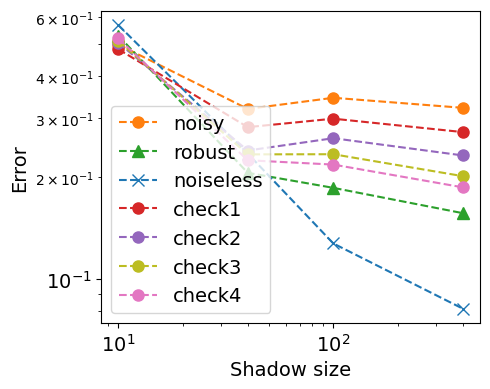

In [103]:
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(shadow_range, errors['shadow'], '--o', ms=8, color='tab:orange', label='noisy')
plt.plot(shadow_range, errors['shadow_r'], '--^', ms=8, color='tab:green', label='robust')
plt.plot(shadow_range, errors['noiseless'], '--x', ms=8, color='tab:blue', label='noiseless')
plt.plot(shadow_range, errors['check1'], '--o', ms=8, color='tab:red', label='check1')
plt.plot(shadow_range, errors['check2'], '--o', ms=8, color='tab:purple', label='check2')
plt.plot(shadow_range, errors['check3'], '--o', ms=8, color='tab:olive', label='check3')
plt.plot(shadow_range, errors['check4'], '--o', ms=8, color='tab:pink', label='check4')
plt.legend(fontsize=14, loc='best')
plt.xlabel('Shadow size', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

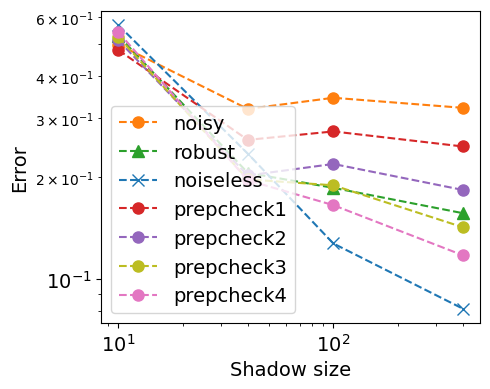

In [122]:
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(shadow_range, errors['shadow'], '--o', ms=8, color='tab:orange', label='noisy')
plt.plot(shadow_range, errors['shadow_r'], '--^', ms=8, color='tab:green', label='robust')
plt.plot(shadow_range, errors['noiseless'], '--x', ms=8, color='tab:blue', label='noiseless')
plt.plot(shadow_range, errors['prepcheck1'], '--o', ms=8, color='tab:red', label='prepcheck1')
plt.plot(shadow_range, errors['prepcheck2'], '--o', ms=8, color='tab:purple', label='prepcheck2')
plt.plot(shadow_range, errors['prepcheck3'], '--o', ms=8, color='tab:olive', label='prepcheck3')
plt.plot(shadow_range, errors['prepcheck4'], '--o', ms=8, color='tab:pink', label='prepcheck4')
plt.legend(fontsize=14, loc='best')
plt.xlabel('Shadow size', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

Calculate Extrapolated Checks

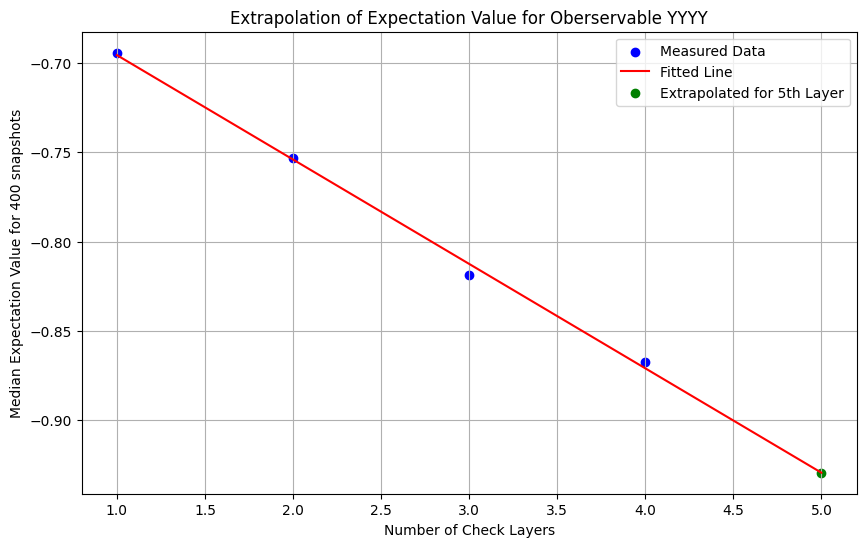

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

medians = [np.median(check, axis=2) for check in [expectations[f"prepcheck{k+1}"] for k in range(num_checks)]]

shadow_size_index = -1  # largest shadow size
pauli_index = 1  # Example observable index
expectation_values = [median[shadow_size_index, pauli_index] for median in medians]

# Fit a Straight Line
check_numbers = [1, 2, 3, 4]  # Numeric x-values for fitting
polynomial = Polynomial.fit(check_numbers, expectation_values, 1)

# Extrapolate to the Fifth Layer
extrapolated_check = 5
extrapolated_value = polynomial(extrapolated_check)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(check_numbers, expectation_values, color='blue', label='Measured Data')
plt.plot(np.linspace(1, 5, 400), polynomial(np.linspace(1, 5, 400)), color='red', label='Fitted Line')
plt.scatter([extrapolated_check], [extrapolated_value], color='green', label='Extrapolated for 5th Layer')

plt.xlabel('Number of Check Layers')
plt.ylabel(f'Median Expectation Value for {shadow_range[shadow_size_index]} snapshots')
plt.title(f'Extrapolation of Expectation Value for Oberservable {Paulis[pauli_index]}')
plt.legend()
plt.grid(True)
plt.show()

In [124]:
check_numbers = [1, 2, 3]  # Original check layers
extrapolation_layers = range(4, 5)  # Layers 4 to 8 inclusive
medians = [np.median(check, axis=2) for check in [expectations[f"prepcheck{k+1}"] for k in range(len(check_numbers))]]

# Initialize a three-dimensional array to store extrapolated values
# Dimensions: [extrapolated layers, shadow size, Paulis]
expectation_check_limit = np.zeros((len(extrapolation_layers), len(shadow_range), len(Paulis)))

for layer_index, layer in enumerate(extrapolation_layers):
    for shadow_size_index in range(len(medians[0])):
        for pauli_index in range(medians[0].shape[1]):
            expectation_values = [median[shadow_size_index, pauli_index] for median in medians]
            polynomial = Polynomial.fit(check_numbers, expectation_values, 1)
            # Extrapolate the value for the current layer
            extrapolated_value = polynomial(layer)
            expectation_check_limit[layer_index, shadow_size_index, pauli_index] = extrapolated_value

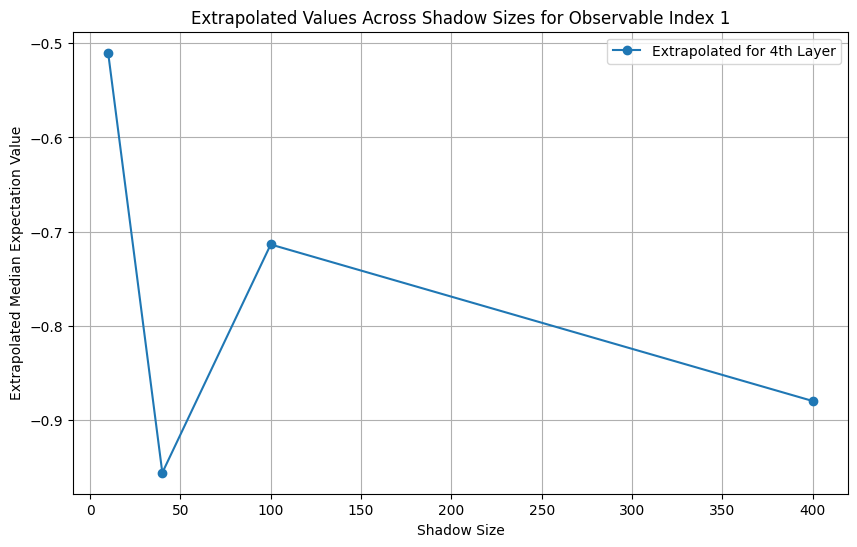

In [125]:
# Example Plotting for a specific Pauli index across all shadow sizes
pauli_index = 1  
shadow_size_index = -1 # largest shadow size

plt.figure(figsize=(10, 6))
# Plotting the extrapolated values for each extrapolated layer for the specific observable and shadow size
for layer_index, layer in enumerate(extrapolation_layers):
    plt.plot(shadow_range, expectation_check_limit[layer_index, :, pauli_index], marker='o', linestyle='-', label=f'Extrapolated for {layer}th Layer')

plt.xlabel('Shadow Size')
plt.ylabel(f'Extrapolated Median Expectation Value')
plt.title(f'Extrapolated Values Across Shadow Sizes for Observable Index {pauli_index}')
plt.legend()
plt.grid(True)
plt.show()

### Compute mean error for each extrapolated check

In [126]:
error_check_limit = np.zeros((len(extrapolation_layers), len(shadow_range)))

for layer_index, layer in enumerate(extrapolation_layers):
    for shadow_size_index in range(len(shadow_range)):
        # Calculate the mean error for this layer and shadow size across all Pauli indices
        error_check_limit[layer_index, shadow_size_index] = np.mean(
            [np.abs(expectation_check_limit[layer_index, shadow_size_index, pauli_index] - ref_list[pauli_index]) for pauli_index in range(len(Paulis))]
        )

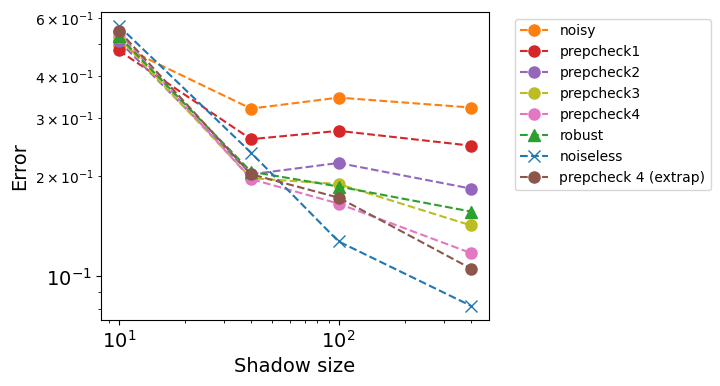

In [129]:
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(shadow_range, errors['shadow'], '--o', ms=8, color='tab:orange', label='noisy')
plt.plot(shadow_range, errors['prepcheck1'], '--o', ms=8, color='tab:red', label='prepcheck1')
plt.plot(shadow_range, errors['prepcheck2'], '--o', ms=8, color='tab:purple', label='prepcheck2')
plt.plot(shadow_range, errors['prepcheck3'], '--o', ms=8, color='tab:olive', label='prepcheck3')
plt.plot(shadow_range, errors['prepcheck4'], '--o', ms=8, color='tab:pink', label='prepcheck4')
plt.plot(shadow_range, errors['shadow_r'], '--^', ms=8, color='tab:green', label='robust')
plt.plot(shadow_range, errors['noiseless'], '--x', ms=8, color='tab:blue', label='noiseless')

# Plotting each layer of extrapolated checks
colors = ['tab:brown', 'tab:gray', 'tab:cyan', 'tab:pink', 'tab:purple']  # Example colors for different layers
for layer_index, layer in enumerate(extrapolation_layers):
    plt.plot(shadow_range, error_check_limit[layer_index, :], '--o', ms=8, color=colors[layer_index % len(colors)], label=f'prepcheck {layer} (extrap)')

# plt.legend(fontsize=14, loc='best')
# plt.xlabel('Shadow size', fontsize=14)
# plt.ylabel('Error', fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
# plt.tick_params(labelsize=14)
# plt.tight_layout()

# plt.savefig('non_ideal_checks.png', dpi=100)
# plt.show()

# Adjust the legend to be outside without altering the figure size
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlabel('Shadow size', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)

# Note: The figure's layout isn't altered with plt.tight_layout() in this case
# Saving the figure with bbox_inches='tight' includes the external legend
plt.savefig('non_idealchecks.png', dpi=100, bbox_inches="tight")
plt.show()
